# Import required libraries

In [3]:
import os
import pickle
from tqdm.notebook import tqdm
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from nltk.translate.bleu_score import corpus_bleu

# Mount Google Drive to Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# To unmount Google Drive from Google Colab

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##Reach our project folder where all files are available


In [5]:
# List all files in the "Colab Notebook" folder
colab_folder = '/content/drive/MyDrive/Colab Notebooks/'
os.listdir(colab_folder)


['Flicker8k_Dataset',
 'best_model.h5',
 'features.pkl',
 'ImageCaptionProject.ipynb']

# Access directories

In [6]:
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset'
WORKING_DIR = '/content/drive/MyDrive/Colab Notebooks'

Extract Image Features

In [7]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR,'Flickr8k_Dataset_Unzip_Images')

for img_name in tqdm(os.listdir(directory)):
  # load the image from file
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  # convert image pixels to numpy array
  image = img_to_array(image);
  len(image)
  # reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # preprocess image for VGG16
  image = preprocess_input(image)
  # extract feature
  feature = model.predict(image, verbose=0)
  # get image ID
  image_id = img_name.split('.')[0]
  # store feature
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
# store features in a pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'),'wb'))

In [10]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as file:
  features = pickle.load(file)

## Load the captions Data

In [11]:
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt'), 'r') as file:
  # next(file)
  captions_doc = file.read()
  # captions_doc

In [12]:
# Create mapping of image to captions
mapping = {}
# Process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by dot(.)
    tokens = line.split('.')
    if len(tokens) < 2:  # Fix: Check tokens, not the length of the line
        continue
    image_id, caption_parts = tokens[0], tokens[1:]
    # Remove extension from Image_Id
    image_id = image_id.split('.')[0]
    # Remove additional extension text from caption parts
    captions = [part.split('\t', 1)[1] for part in caption_parts if '\t' in part]
    # Convert caption list to string
    caption = " ".join(captions)
    # Create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [13]:
len(mapping)
# mapping

8092

##Preprocess Text Data

In [14]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocessing steps
      # convert to lowercase
      caption = caption.lower()
      # delete digits, special chars, etc...
      caption = caption.replace('[A-Za-z]','')
      # delete additional spaces
      caption = caption.replace('\s+',' ')
      # add <start> and <end> tags to the caption
      caption = 'start '+" ".join([word for word in caption.split() if len(word)>1])+' end'
      captions[i]=caption

In [15]:
# before preprocess of text
mapping['102351840_323e3de834']

['A man drilling a hole in the ice ',
 'A man is drilling through the frozen ice of a pond ',
 'A person in the snow drilling a hole in the ice ',
 'A person standing on a frozen lake ',
 'Two men are ice fishing ']

In [16]:
# preprocess the text
clean(mapping)

In [17]:
# after preprocess of text
mapping['102351840_323e3de834']

['start man drilling hole in the ice end',
 'start man is drilling through the frozen ice of pond end',
 'start person in the snow drilling hole in the ice end',
 'start person standing on frozen lake end',
 'start two men are ice fishing end']

In [18]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [19]:
len(all_captions)
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8471

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

## Train Test Split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
# print(train)
# print(test)

In [23]:
#<start> man drilling hole in the ice <end>
#                                X                                      Y
#<start>                                                                man
#<start>                         man                                    drilling
#<start>                         man drilling                           hole
#<start>                         man drilling hole                      in
#<start>                         man drilling hole in                   .......
#..........................................................................................
# <start> man drilling hole in the ice <end>

In [24]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    """
    Data generator for yielding batches of data to avoid session crashes.

    Parameters:
    - data_keys: List of keys identifying data samples.
    - mapping: Dictionary mapping keys to captions.
    - features: Dictionary mapping keys to image features.
    - tokenizer: Tokenizer for converting text to sequences.
    - max_length: Maximum length of input sequences.
    - vocab_size: Size of the vocabulary for one-hot encoding.
    - batch_size: Number of samples per batch.

    Yields:
    - ((X1, X2), Y): Tuple of feature arrays, input sequences, and one-hot encoded output sequences.
    """
    X1, X2, Y = [], [], []
    n = 0

    while True:
        for key in data_keys:
            if key not in mapping or key not in features:
                print(f"Warning: Key '{key}' is missing in mapping or features. Skipping...")
                continue

            captions = mapping[key]
            # Process each caption for the current image
            for caption in captions:
                # Encode the caption to a sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Create X-Y pairs from the sequence
                for i in range(1, len(seq)):
                    # Split into input and output
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # One-hot encode the output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append to batch lists
                    X1.append(features[key][0])  # Assuming features[key] is a list
                    X2.append(in_seq)
                    Y.append(out_seq)

                    n += 1

                    # Yield the batch when full
                    if n == batch_size:
                        yield ((np.array(X1), np.array(X2)), np.array(Y))
                        X1, X2, Y = [], [], []
                        n = 0

        # Reset n to allow for partial batches if the dataset size isn't a perfect multiple of batch_size
        if n > 0:
            yield ((np.array(X1), np.array(X2)), np.array(Y))
            X1, X2, Y = [], [], []
            n = 0


##Model Creation


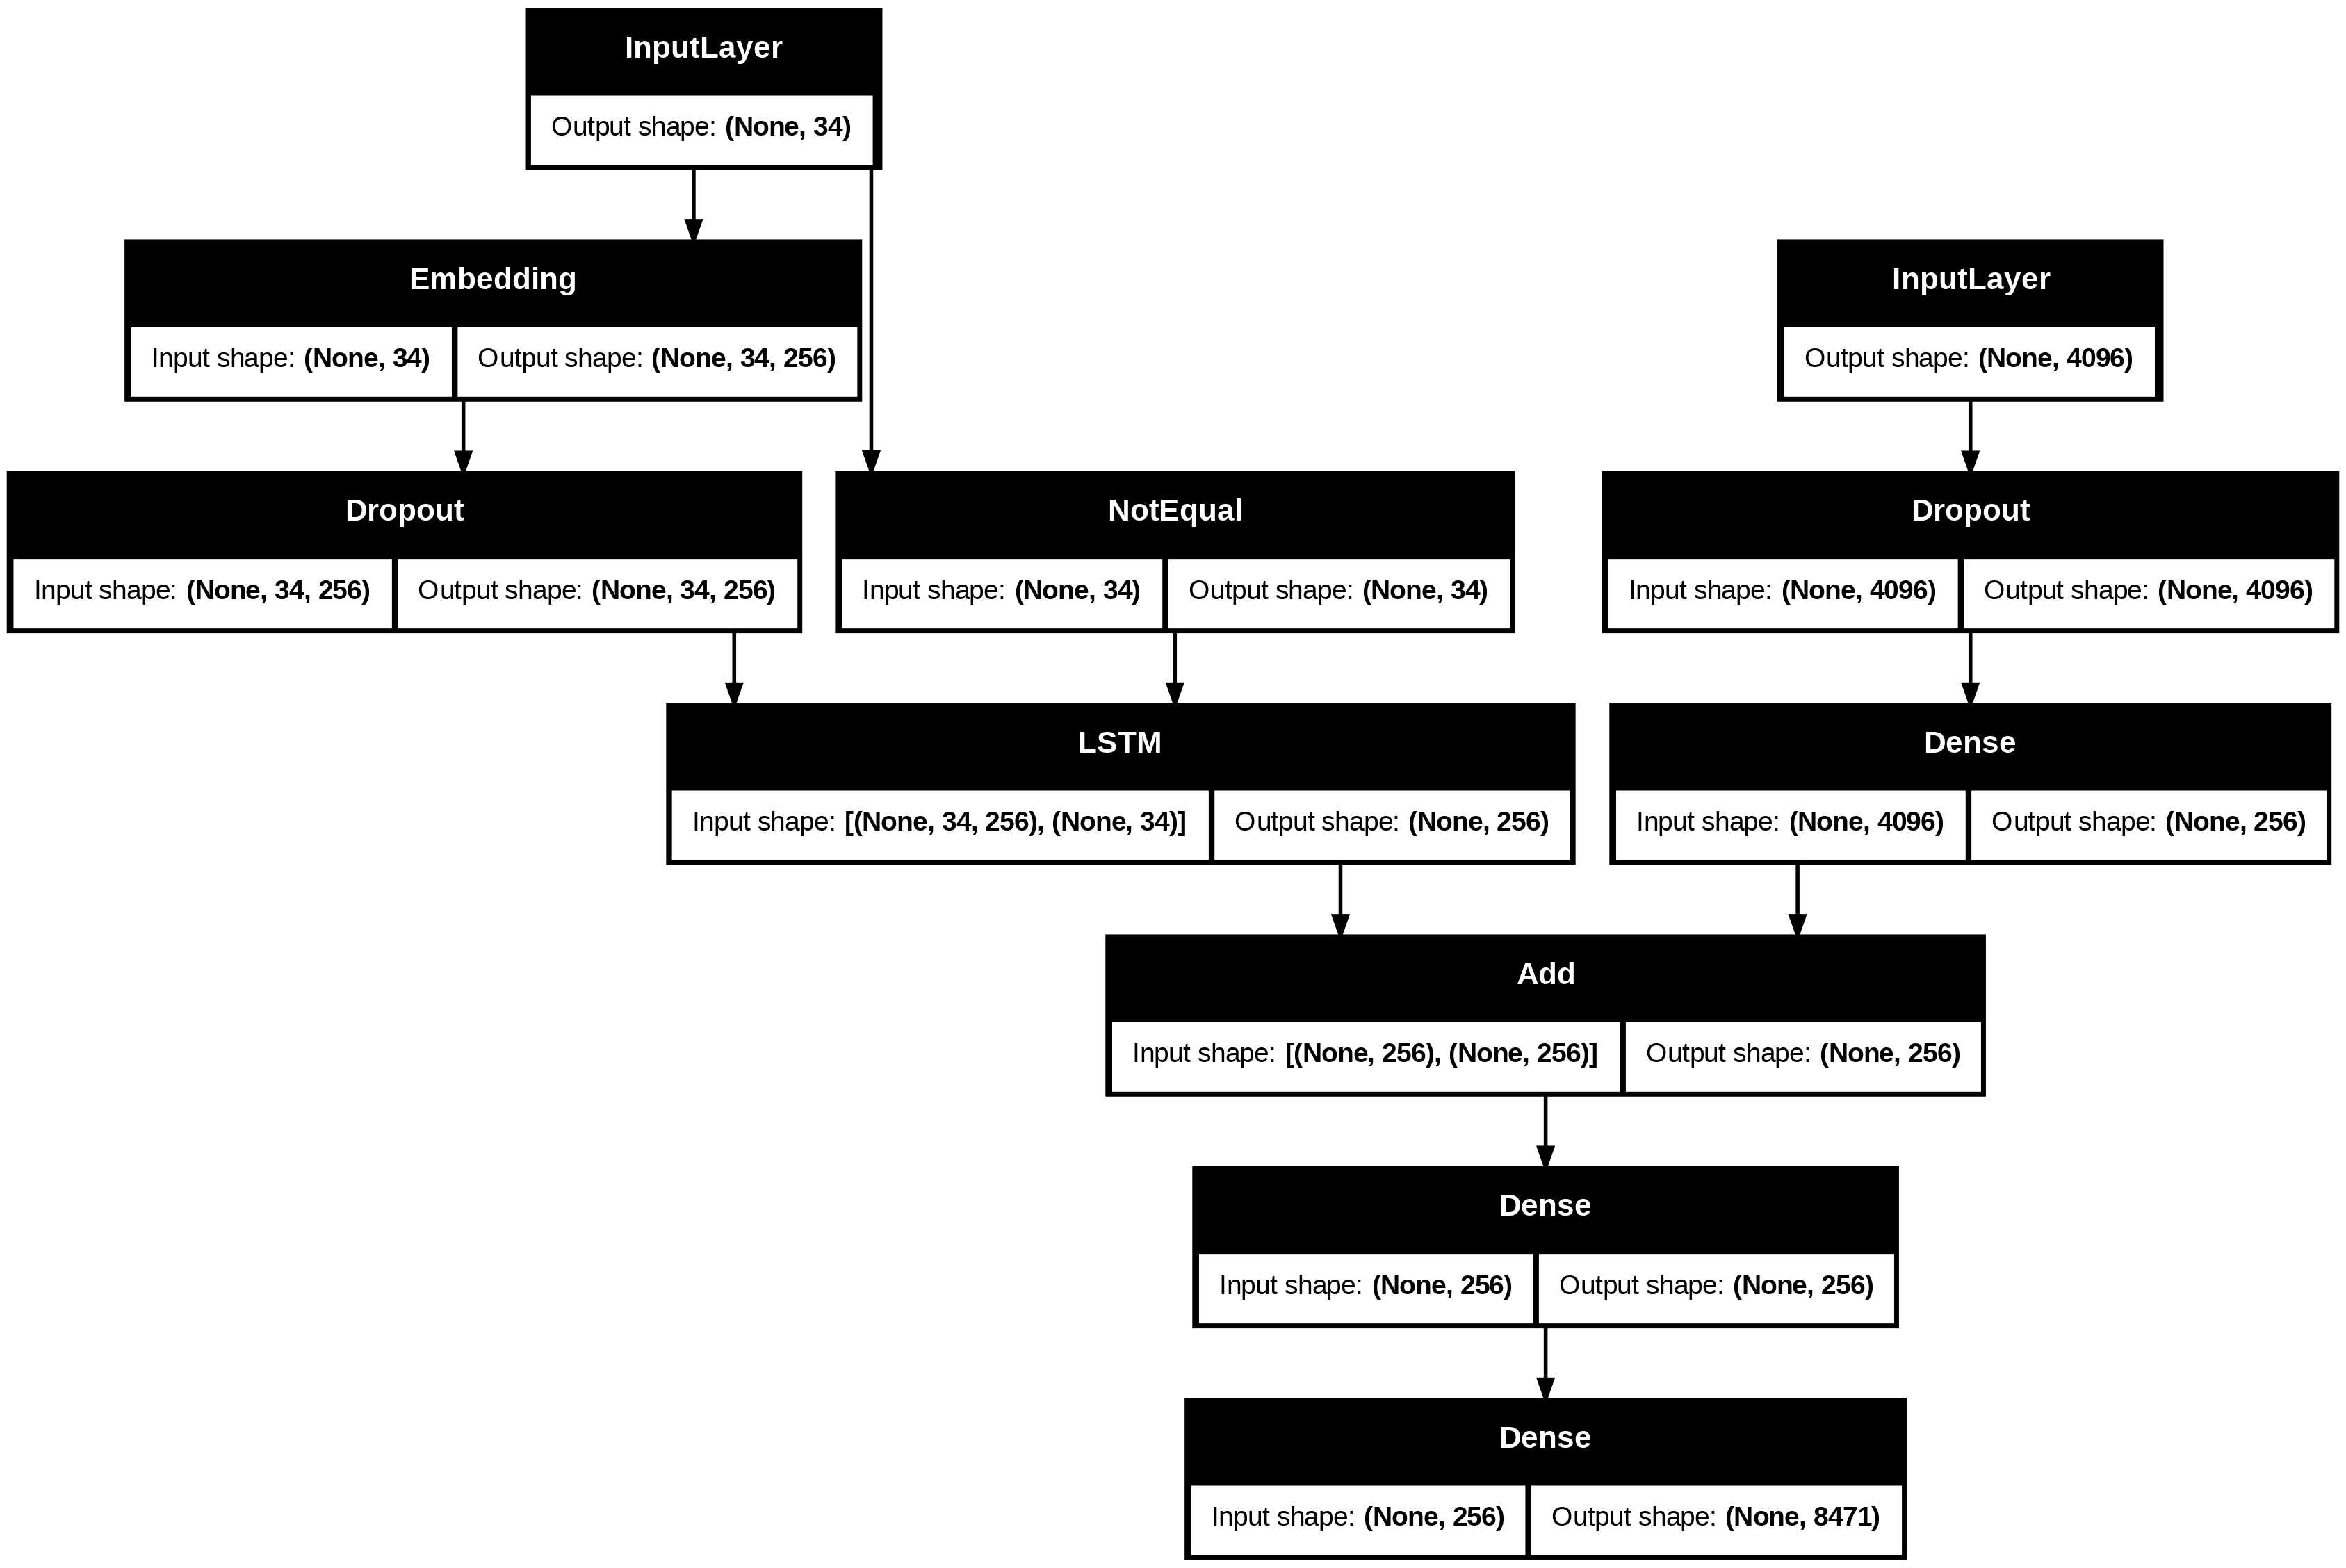

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [27]:
print("Keys in train but not in features:", set(train) - set(features.keys()))
print("Keys in features but not in train:", set(features.keys()) - set(train))

Keys in train but not in features: {'2258277193_586949ec62'}
Keys in features but not in train: {'689359034_4a64c24ca4', '479807833_85eed6899c', '667626_18933d713e', '509241560_00e5b20562', '518610439_b64ab21c02', '456299217_b2802efbc2', '918886676_3323fb2a01', '556568556_bc5124dc8e', '457631171_12b1aee828', '710878348_323082babd', '861795382_5145ad433d', '635444010_bd81c89ab7', '525968880_82623392d1', '847782643_57248bbdab', '798343627_7492fe0c12', '500446858_125702b296', '449352117_63c359c6e7', '661546153_9d30db6984', '464506846_1734302b58', '530661899_94655d7d0e', '532131603_c82d454c8a', '477768471_d7cd618fdb', '466176275_f40d37851e', '530950375_eea665583f', '482882719_165722082d', '447722389_4b51b7e13d', '527272653_8a5bd818e5', '804087017_330bcc8c56', '462080147_ca088e6541', '818340833_7b963c0ee3', '576920249_df1bdc2068', '516725192_c9cdd63878', '824123145_59243e504e', '687513087_413d4a3a3b', '484896012_7787d04f41', '483841513_e660391880', '561179890_af8e31cb2e', '543102698_38e7e38

In [28]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 6.8720
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1992
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7546
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3690
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.9599
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.6627
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4889
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3014
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1216
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7985
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6511
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.5478
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3488
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1989


In [29]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate captions for the image

In [30]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [40]:
# Generate a caption for an image
def predict_caption(model, image, tokenizer, max_length):
    """
    Generate a caption for a given image using a trained model.

    Args:
        model: The trained image captioning model.
        image: The processed image input to the model.
        tokenizer: The tokenizer used to convert text to sequences.
        max_length: The maximum length of the caption sequence.

    Returns:
        A generated caption as a string.
    """
    # Initialize the generated caption with the start token
    in_text = 'start'

    # Generate the caption word by word
    for _ in range(max_length):
        # Convert current input text to a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to the required max length
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # Predict the next word in the sequence
        yhat = model.predict([image, sequence], verbose=0)
        # Get the word index with the highest probability
        yhat = np.argmax(yhat)
        # Convert the word index to the actual word
        word = idx_to_word(yhat, tokenizer)
        # Break if no word is found
        if word is None:
            break
        # Append the predicted word to the caption
        in_text += " " + word
        # Stop if the end token is generated
        if word == 'end':
            break

    # Remove the trailing 'end' token and return the generated caption
    return in_text.replace(' end', '').strip()

In [41]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Validate key presence
    if key not in mapping:
        print(f"Key {key} not found in mapping.")
        continue
    if key not in features or features[key] is None:
        print(f"No features found for key: {key}")
        continue

    # Get actual captions
    captions = mapping[key]
    if not captions:
        print(f"No captions found for key: {key}")
        continue

    # Predict caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    if not y_pred or y_pred.strip() == "":
        print(f"No prediction generated for key: {key}")
        y_pred = "<unk>"

    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # Append to lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# Check list sizes
print(f"Number of actual captions: {len(actual)}")
print(f"Number of predicted captions: {len(predicted)}")

# Calculate BLEU scores if lists are populated
if len(actual) > 0 and len(predicted) > 0:
    from nltk.translate.bleu_score import corpus_bleu
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
else:
    print("No valid data to calculate BLEU scores.")

  0%|          | 0/810 [00:00<?, ?it/s]

Number of actual captions: 810
Number of predicted captions: 810
BLEU-1: 0.290406
BLEU-2: 0.147169


##Visualizes the result

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  # load the iamge
  image_id = image_name.split('.')[0]
  img_path = os.path.join(BASE_DIR, "Flickr8k_Dataset_Unzip_Images", image_name)
  image = Image.open(img_path)
  captions = mapping[image_id]
  print('---------------------------------------------------------------Actual--------------------------------------------------------------')
  for caption in captions:
    print(caption)
  # predict the caption
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  print('---------------------------------------------------------------Predicted-----------------------------------------------------------')
  print(y_pred)
  plt.imshow(image)

---------------------------------------------------------------Actual--------------------------------------------------------------
start big brown dog plays with smaller grey dog on the grass end
start the dark brown dog is playing with the light brown dog end
start two brown dogs are running through the grass end
start two brown dogs run side by side end
start two dogs running and playing rough in the grass end
---------------------------------------------------------------Predicted-----------------------------------------------------------
start two dogs in blue brown dogs in the water


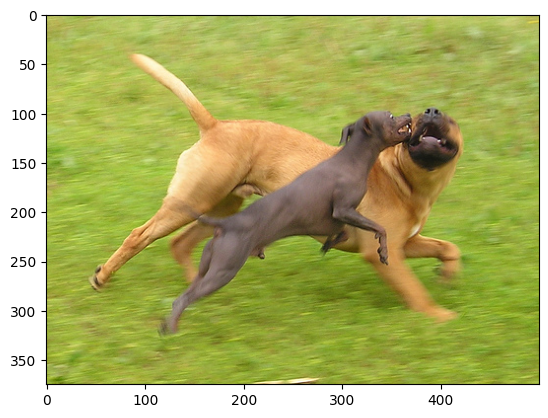

In [43]:
generate_caption("1169307342_e7a4685a5c.jpg")

##UI for best experience

In [44]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [55]:
import gradio as gr
from PIL import Image
import matplotlib.pyplot as plt
import os

# Assuming these variables and functions are pre-defined in your environment
# model, features, tokenizer, max_length, BASE_DIR, mapping, predict_caption

def generate_caption_interface(image_file):
    """
    Takes an uploaded image file and returns both actual and predicted captions.
    """
    try:
        # The uploaded image file comes as a file-like object, we need to open it using PIL
        image_name = os.path.basename(image_file.name)  # Get the filename from the uploaded file
        image = Image.open(image_file.name)  # Open the image using PIL

        # Extract the image ID from the name
        image_id = image_name.split('.')[0]

        # Assuming BASE_DIR and mapping are correctly defined and accessible
        img_path = os.path.join(BASE_DIR, "Flickr8k_Dataset_Unzip_Images", image_name)

        # Check if the image file exists
        if not os.path.exists(img_path):
            return f"Error: The image path {img_path} does not exist. Please check the file path."

        # Retrieve actual captions from the mapping (ensure `image_id` exists in `mapping`)
        if image_id not in mapping:
            return f"Error: No captions found for image ID {image_id}."

        captions = mapping.get(image_id, [])
        actual_captions = '\n'.join(captions) if captions else "No captions available."

        # Predict the caption using your prediction model
        if image_id not in features:
            return f"Error: No features found for image ID {image_id}."

        predicted_caption = predict_caption(model, features[image_id], tokenizer, max_length)

        # Return both actual and predicted captions as formatted text
        # result_text = f"Actual Captions:\n{actual_captions}\n\nPredicted Caption:\n{predicted_caption}"
        result_text = f"Predicted Caption:\n{predicted_caption}"

        # Return both the image and the caption results
        return image, result_text

    except Exception as e:
        return f"An unexpected error occurred: {str(e)}"

# Gradio interface using File upload (gr.File)
interface = gr.Interface(
    fn=generate_caption_interface,
    inputs=gr.File(label="Upload Image"),  # Use "File" type to get file path
    outputs=[gr.Image(type="pil", label="Uploaded Image"), gr.Textbox(label="Captions", lines=10)],  # Display image and captions
    title="Image Caption Generator",
    description="Upload an image to view both actual and predicted captions."
)

# Launch the interface
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://49a65e7b522e3af7a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
